In [1]:
# %load /Users/hwayment/ipynb_defaults.py
%load_ext autoreload
%autoreload 2

%pylab inline
import numpy as np
import pandas as pd

import seaborn as sns
sns.set_style('ticks')
sns.set_context('paper')

import eternabench as eb

Populating the interactive namespace from numpy and matplotlib


In [2]:
df = pd.read_csv('SHAPE_guided_all_constructs_6Jun2022_PLUSSCORES.txt',delimiter='\t')
packages = ['SHAPEknots','RNAstructure+SHAPE/DMS','RNAstructure','ViennaRNA (Washietl)','ViennaRNA (Deigan)',
            'ViennaRNA (Zaringhalam)','ViennaRNA (RNAfold)','EternaFold','EternaFold+SHAPE/DMS']

In [3]:
# Melt dataframe for sake of plotting

df_melt = df.melt(id_vars=['name','dataset','Public URL to data','modifier','GT_struct','sequence','reactivity'],
                  value_vars=['MCC '+x for x in packages], var_name='package', value_name='MCC')
df_melt['package'] = [x.replace('MCC ','') for x in df_melt.package]

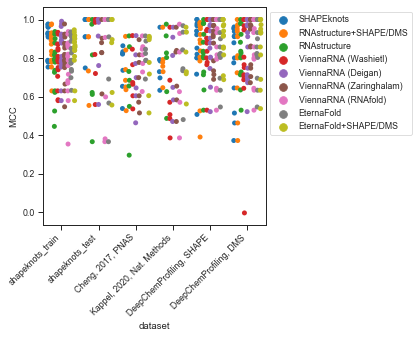

In [4]:
figure(figsize=(4,4))
sns.stripplot(x='dataset',y='MCC',hue='package',data=df_melt,dodge=True)
xticks(rotation=45,horizontalalignment='right')
legend(bbox_to_anchor=(1,1))

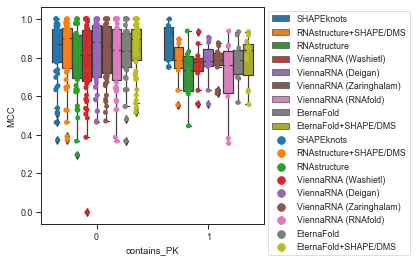

In [5]:
df_melt['contains_PK'] = np.where(df_melt['GT_struct'].str.contains('<'),1,0)

figure(figsize=(4,4))
sns.stripplot(x='contains_PK',y='MCC',hue='package',data=df_melt,dodge=True)
sns.boxplot(x='contains_PK',y='MCC',hue='package',data=df_melt,dodge=True)

legend(bbox_to_anchor=(1,1))

In [6]:
# Resample from within each dataset 1000x

# Use this to calculate Z-scores

test_datasets = ['shapeknots_test', 'Cheng, 2017, PNAS', 'Kappel, 2020, Nat. Methods', 'DeepChemProfiling, SHAPE', 'DeepChemProfiling, DMS']

bootstrapped_df = pd.DataFrame()

for bs_ind in range(1000):
    for ds in test_datasets:
        tmp = df.loc[df.dataset==ds]
        tmp = tmp.sample(replace=True)
        tmp['bs_ind'] = bs_ind
        bootstrapped_df = bootstrapped_df.append(tmp, ignore_index=True)

bs_df_melt = bootstrapped_df.melt(id_vars=['dataset','bs_ind'], value_vars=['MCC '+x for x in packages], var_name='package', value_name='MCC')
bs_df_melt['package'] = [x.replace('MCC ','') for x in bs_df_melt.package]
bs_df_melt = bs_df_melt.rename(columns={'dataset':'Dataset'})

(6, 3) [1, 1]


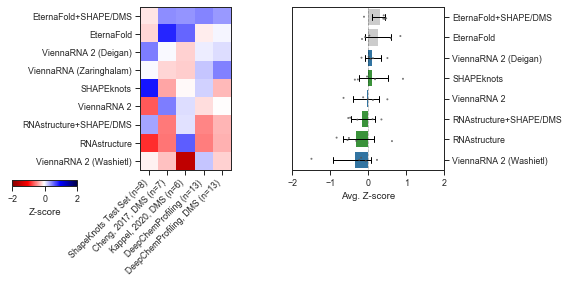

In [7]:
xticklabels=['ShapeKnots Test Set (n=8)',
            'Cheng, 2017, DMS (n=7)',
            'Kappel, 2020, DMS (n=6)',
            'DeepChemProfiling (n=13)',
            'DeepChemProfiling, DMS (n=13)']

zscores, rank = eb.stats.calculate_Z_scores(bs_df_melt, dataset_list = test_datasets, metric='MCC')

eb.plot.ranked_heatmap(zscores, metric='MCC_zscore_by_Dataset_mean', dataset_order=test_datasets, dataset_labels=xticklabels, vmin=-2,vmax=2,size=2, figsize=(6,3), width_ratios=[1,1])